# Volume Weighted Average vs Simple Moving Average

We are developing a simple model to test if the volume weighted average price (VWAP) is a better indicator of future stock price than a simple moving average price (SMAP). Our hypothesis is that it is, since the VWAP contains more information (i.e. the volume of stocks traded) than the SMAP. Before developing the model, we first give some definitions.

For our purposes, we define the VWAP of stock $A$ as
$$\mathrm{VWAP}_{A}(d) = \frac{\sum_{t=-d}^{0} p_{A}(t)\times V_{A}(t)}{\sum_{t=-d}^{0} V_{A}(t)}$$
Here $p_{A}(d)$ and $V_{A}(d)$ are the closing price of stock $A$ and the volume of stock $A$ (number of shares) , respectively, traded $d$ market days ago. The variable $d$ thus serves as the anchoring point for the volume weighted average.

The SMAP of stock $A$ is defined as
$$\mathrm{SMAP}_{A}(d) = \frac{1}{d+1}\sum_{t=-d}^{0} p_{A}(t)$$
where $d$ is again the lookback period.

To test the model, we will analyze the stocks that constitute the MMI. Our data came from [kaggle](https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs).

### Reading in historical data
We will start by reading in the historical data for stocks in the NYSE ARCA Major Market Index

In [14]:
# Lets first import some useful libraries for data analysis
import numpy as np
import pandas as pd
from pandas.plotting import _converter
_converter.register()
import matplotlib.pyplot as plt
import matplotlib.dates  as dates

# Create a dictionary of stock ticker symbols
ARCAMMI_Stocks={'AmericanExpress':'axp',
                'Boeing':'ba',
                'Chevron':'cvx',
                'DowDupont':'dwdp',
                'Disney':'dis',
                'GeneralElectric':'ge',
                'HewlettPackard':'hpq',
                'IBM':'ibm',
                'JohnsonAndJohnson':'jnj',
                'JPMorgan':'jpm',
                'CocaCola':'ko',
                'McDonalds':'mcd',
                '3M':'mmm',
                'Merck':'mrk',
                'Microsoft':'msft',
                'ProcterAndGamble':'pg',
                'WellsFargo':'wfc',
                'Walmart':'wmt',
                'ExxonMobil':'xom'}

# Read in the historical data
historical_data = {}
for key, ticker in ARCAMMI_Stocks.items():
    historical_data[key] = pd.read_csv('MMI_DATA/'+ticker+'.us.txt',index_col=0)

We have access to the following data:
	 Open
	 High
	 Low
	 Close
	 Volume
	 OpenInt


Historical Closing Price for Disney Stock:


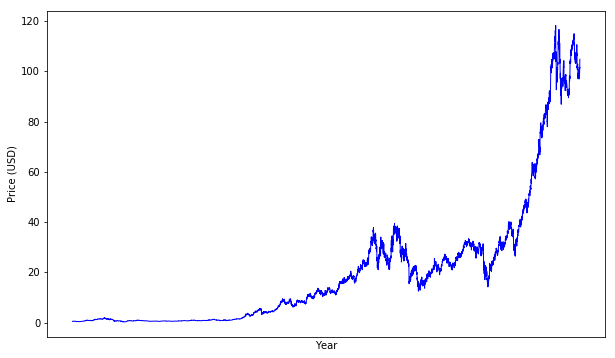

In [17]:
# Lets see what other data we have available to us
print('We have access to the following data:')
for col in historical_data['Disney'].columns.values:
    print('\t',col)


# Lets go ahead and take a look at Disney's historical closing price
print('\n\nHistorical Closing Price for Disney Stock:')
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot_date(historical_data['Disney'].index.values, historical_data['Disney']['Close'],
             color='blue',linewidth=1,marker='',linestyle='-')

#print dates.YearLocator()
ax.xaxis.set_major_locator(dates.YearLocator(base=5))
ax.set_xlabel('Year')
ax.set_ylabel('Price (USD)')
plt.show()
plt.close()


## VWAP and SMAP Functions

Now that we have got the stock data in, lets write some functions to calculate the VWAP and SMAP

In [18]:
def get_vwap(price,volume,d):
    """Return the VWAP anchored d days back"""
    vwap = np.zeros(len(price))
    for i in range(d,len(price)):
        lb = i - d #lower bound
        ub = i + 1 #upper bound
        vwap[i] = np.multiply(price[lb:ub],volume[lb:ub]).sum()
        vwap[i] /= np.sum(1.*volume[lb:ub])
    return vwap

def get_smap(price,d):
    """Return the SMAP anchored d days back"""
    smap = np.zeros(len(price))
    for i in range(d,len(price)):
        lb = i - d #lower bound
        ub = i + 1 #upper bound
        smap[i] = np.sum(price[lb:ub])/(d+1.)
    return smap

## Generate VWAP and SMAP Data
Now that we have functions to calculate VWAP and SMAP, lets go ahead and generate the data using an anchor of 15 days and the stock closing price.

In [19]:
lookback = 15
for company in historical_data:
    historical_data[company]['VWAP'] = get_vwap(historical_data[company]['Close'],historical_data[company]['Volume'],lookback)
    historical_data[company]['SMAP'] = get_smap(historical_data[company]['Close'],lookback)

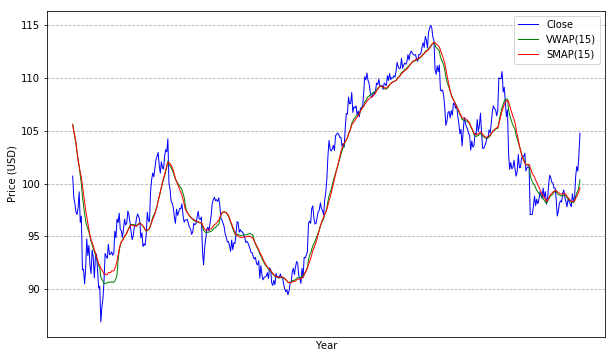

In [20]:
# Lets go ahead and take a look at the disney data from 2016 on
start = '2016-01-01'
fig, ax2 = plt.subplots(1,1,figsize=(10,6))

ax2.plot_date(historical_data['Disney'][start:].index.values, historical_data['Disney'][start::]['Close'],
             color='blue',linewidth=1,marker='',linestyle='-',label='Close')
ax2.plot_date(historical_data['Disney'][start:].index.values, historical_data['Disney'][start::]['VWAP'],
             color='green',linewidth=1,marker='',linestyle='-',label='VWAP('+str(lookback)+')')
ax2.plot_date(historical_data['Disney'][start:].index.values, historical_data['Disney'][start::]['SMAP'],
             color='red',linewidth=1,marker='',linestyle='-',label='SMAP('+str(lookback)+')')

ax2.xaxis.set_major_locator(dates.MonthLocator(interval=2))
ax2.xaxis.set_major_formatter(dates.DateFormatter("%b '%y"))
ax2.set_xlabel('Year')
ax2.set_ylabel('Price (USD)')
ax2.legend()
ax2.grid(linestyle='dashed')
plt.show()
plt.close()

## A Simple Strategy

We are going to implement a strategy based on the following principles:

1. When the price is above the SMAP or the VWAP, we are going to be in a long position.
2. When the price is below the SMAP or the VWAP, we are going to be in a cash position.

We want to run tests for diffent number of lookback days for calculating SMAP and VWAP to see if we can find an optimal value for outperforming the benchmark, which is just a buy and hold strategy, and to see if the number of lookback days affects the performance of VWAP vs SMAP.

Some questions we hope to answer:
1. What is the optimal number of looback days
2. How many signals are different between VWAP and SMAP

In [6]:
# Here define some functions to calculate our signals and values 

# if the price is greater than VWAP or SMAP, we want to go long (1), otherwise we want to be in a cash position (0)
def set_signal(metric, price, lookback):
    signal = np.zeros(len(price))
    for i in range(len(price)):
        if price[i] > metric[i] and i >= lookback:
            signal[i] = 1
            
    return signal

# Now, we want to calculate the value of our portfolio
# I think this is working correctly
def set_value(signal,openprice):
    value = np.zeros(len(signal))
    value[0] = 1.
    for i in range(1,len(signal)):
        delta = (openprice[i] - openprice[i-1])/(openprice[i-1])
        value[i] = value[i-1]*(1 + signal[i-1]*delta)
        
    return value

Lets test the strategy using a lookback of 15 days for the returns since 2010 for all stocks in the MMI. I don't want to go back as far as possible because then the returns seem unrealistic. There is something I don't quite understand that is contributing to these excetional returns.

The signal is calculated based on the closing price for a given day, and action is taken the next day at the market opening.

In [7]:
# first get data in a new data frame for all stocks since 2010
start = '2010-01-01'
modern_data = {}
for company in historical_data:
    modern_data[company] = historical_data[company].copy().loc[start::]
    # note that the lookback time should be the same as the lookback used to calulate the SMAP and VWAP
    modern_data[company]['SMAP_Signal'] = set_signal(modern_data[company]['SMAP'], modern_data[company]['Close'], lookback)
    modern_data[company]['VWAP_Signal'] = set_signal(modern_data[company]['VWAP'], modern_data[company]['Close'], lookback)
    modern_data[company]['SMAP_Value']  = set_value (modern_data[company]['SMAP_Signal'], modern_data[company]['Open'])
    modern_data[company]['VWAP_Value']  = set_value (modern_data[company]['VWAP_Signal'], modern_data[company]['Open'])
    
    # also calculate the benchmark signal and value
    bm_signal = np.ones(len(modern_data[company]['Open']))
    bm_signal[0:15] = 0 # we don't want a headstart on the benchmark...
    modern_data[company]['BM_Signal'] = bm_signal
    modern_data[company]['BM_Value']  = set_value (modern_data[company]['BM_Signal'], modern_data[company]['Open'])
    
# and lets go ahead and take a look at Disney
modern_data['Disney'].tail(1)

,Open,High,Low,Close,Volume,OpenInt,VWAP,SMAP,SMAP_Signal,VWAP_Signal,SMAP_Value,VWAP_Value,BM_Signal,BM_Value
Date,,,,,,,,,,,,,,
2017-11-10,104.99,106.24,104.08,104.78,16698113,0,100.365933,99.61375,1.0,1.0,24.500277,26.173498,1.0,3.860068


## Initial visualization

Here, we plot the VWAP vs SMAP. We also plot the diagonal. Points above the diagonal mean that the VWAP outperformed the SMAP and points below the diagonal mean that the VWAP underperformed the SMAP. For the most part, we see that the points lie close to the diagonal, indicating that the strategies perform similarly. However, this strategy performs much better than a simple buy and hold strategy. We will need to do more in depth analysis to test our strategy further.

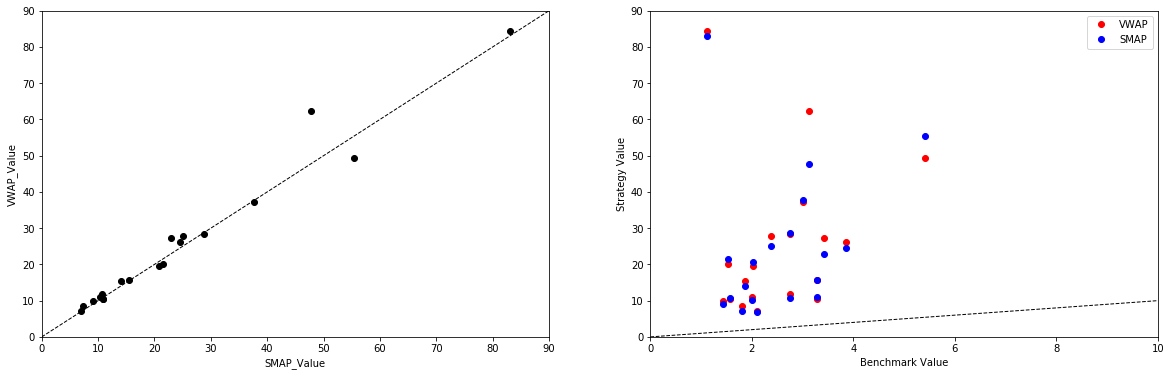

In [8]:
# First, lets get the relevant data
smaps = []
vwaps = []
bms   = []
for company in modern_data:
    smaps.append(modern_data[company].iloc[-1]['SMAP_Value'])
    vwaps.append(modern_data[company].iloc[-1]['VWAP_Value'])
    bms.append(modern_data[company].iloc[-1]['BM_Value'])

smaps = np.array(smaps)
vwaps = np.array(vwaps)
bms   = np.array(bms)
    
# Make the plot of SMAP vs VWAP
fig, ax = plt.subplots(1,2,figsize=(20,6))
ax[0].plot(smaps,vwaps,marker='o',linestyle='', color = 'black')
ax[0].plot([0,100],[0,100],linestyle='--',linewidth=1, color = 'black')
ax[0].set_xlabel('SMAP_Value')
ax[0].set_ylabel('VWAP_Value')
ax[0].set_xlim([0,90])
ax[0].set_ylim([0,90])


ax[1].plot(bms,vwaps,marker='o',linestyle='', color = 'red',label='VWAP')
ax[1].plot(bms,smaps,marker='o',linestyle='', color = 'blue',label='SMAP')
ax[1].plot([0,100],[0,100],linestyle='--',linewidth=1, color = 'black')
ax[1].set_xlabel('Benchmark Value')
ax[1].set_ylabel('Strategy Value')
ax[1].legend()
ax[1].set_xlim([0,10])
ax[1].set_ylim([0,90])

# Also plot SMAP and VWAP versus the benchmark
plt.show()

Lets take a look at the average relative return and the standard deviation of VWAP to SMAP and lets plot the distribution to see if it looks normal.

Notably, the standard deviation is on the order of the mean. The distribution also doesn't look normal. Analyzing a larger set of stocks would help give a better idea of the shape of the distribution.

The average return of the vwap strategy relative to the smap strategy is 0.04777 with standard deviation 0.0996


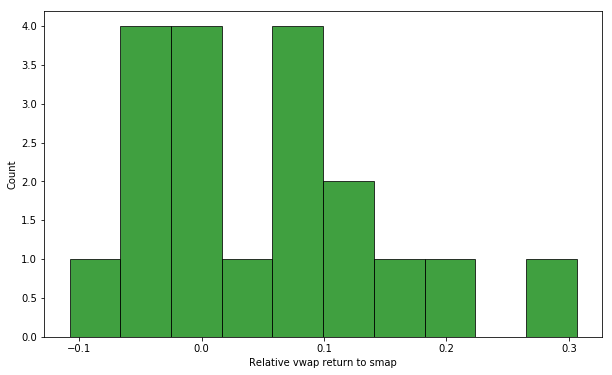

In [9]:
delta          = (vwaps - smaps) / smaps
vwap_smap_mean = delta.mean()
vwap_smap_std  = delta.std()

print("The average return of the vwap strategy relative to the smap strategy is {:.4} \
with standard deviation {:.4}".format(vwap_smap_mean, vwap_smap_std))

fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.hist(delta, 10, facecolor = 'green', alpha=0.75,edgecolor='black')
ax.set_xlabel('Relative vwap return to smap')
ax.set_ylabel('Count')
plt.show()